# GPX Data

I am fortunate to live in New Mexico where I can take beautiful and varied walks, hikes and bike rides nearly every day, which I do. I have been working with GIS data lately, and it crossed my mind that, since I record most of my excursions with an app on my phone, there must be lots of data that I can play with to do mapping and analysis. I was pleased to discover that the simple app I use on my phone to track my excursions can easily export the data to GPX format. I had no idea what GPX format was, but assumed it was some standard, so things looked promising. 

In this article, I will show how I used Python to convert the GPX data to a geopandas GeoDataFrame, from which I can create maps and generate statistical information about the trek. 

In [30]:
import pandas as pd 
import geopandas as gpd 
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from shapely import LineString

In [31]:
trek_df = pd.read_csv('data/wo-2024-09-05.csv')

In [32]:
trek_df.iloc[0]

Id                    wo-2024-09-05
Lat                       41.043858
Lon                      -74.063712
Elev                             79
Time       2024-09-05T15:25:13.004Z
Temp                          20.51
Weather                           0
Name: 0, dtype: object

In [37]:
trek_gdf = gpd.GeoDataFrame( 
    trek_df, 
    geometry=gpd.points_from_xy(x=trek_df.Lon, y=trek_df.Lat)
).set_crs(4269)

In [38]:
trek_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Id        650 non-null    object  
 1   Lat       650 non-null    float64 
 2   Lon       650 non-null    float64 
 3   Elev      650 non-null    int64   
 4   Time      650 non-null    object  
 5   Temp      650 non-null    float64 
 6   Weather   650 non-null    int64   
 7   geometry  650 non-null    geometry
dtypes: float64(3), geometry(1), int64(2), object(2)
memory usage: 40.8+ KB


In [39]:
trek_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [40]:
trek_gdf['Time'] = pd.to_datetime(trek_gdf.Time)

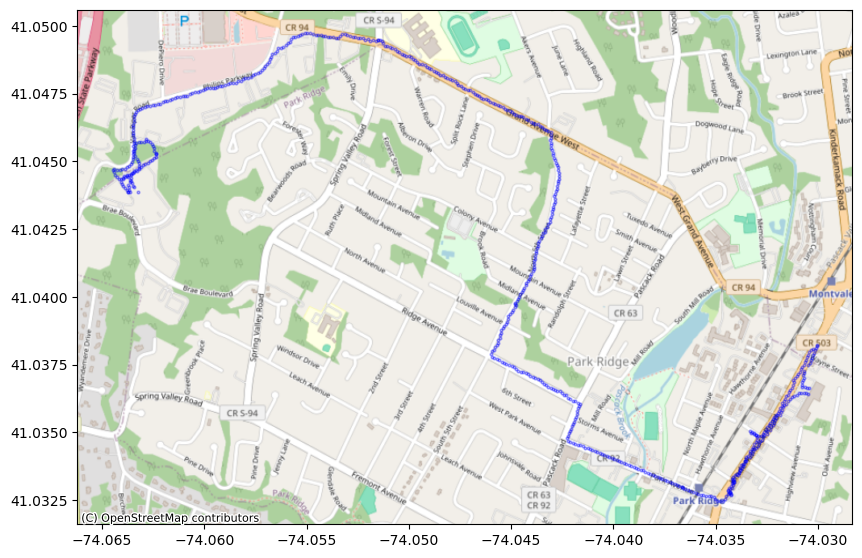

In [41]:
f, ax = plt.subplots(figsize=(10,10))
trek_gdf.plot(ax=ax, alpha=0.3, markersize=4, c='b') 
ctx.add_basemap(ax, crs=trek_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik);

In [42]:
trek_proj = trek_gdf.to_crs(32111)

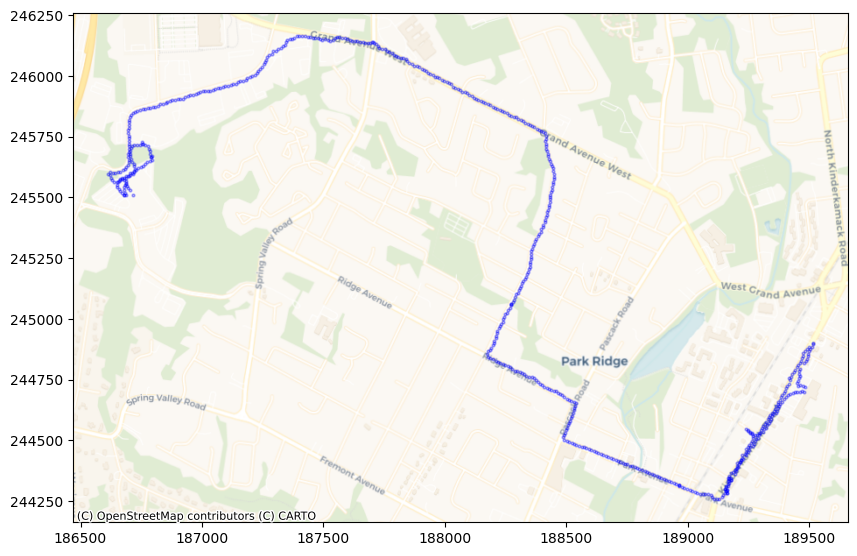

In [43]:
f, ax = plt.subplots(figsize=(10,10))
trek_proj.plot(ax=ax, alpha=0.3, markersize=4, c='b') 
ctx.add_basemap(ax, crs=trek_proj.crs, source=ctx.providers.CartoDB.Voyager);

In [44]:
trek_proj.describe()

,Lat,Lon,Elev,Temp,Weather
count,650.000000,650.000000,650.000000,650.00,650.0
mean,41.041222,-74.046110,45.143077,20.51,0.0
std,0.005818,0.011167,20.266092,0.00,0.0
min,41.032476,-74.064483,11.000000,20.51,0.0
25%,41.035545,-74.056430,24.000000,20.51,0.0
50%,41.042023,-74.044050,49.500000,20.51,0.0
75%,41.046799,-74.035237,63.000000,20.51,0.0
max,41.049728,-74.030031,81.000000,20.51,0.0


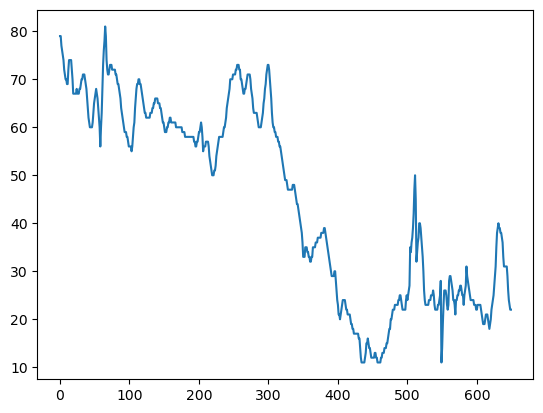

In [47]:
trek_proj.Elev.plot();

In [48]:
trek_proj['Point'] = trek_proj.index

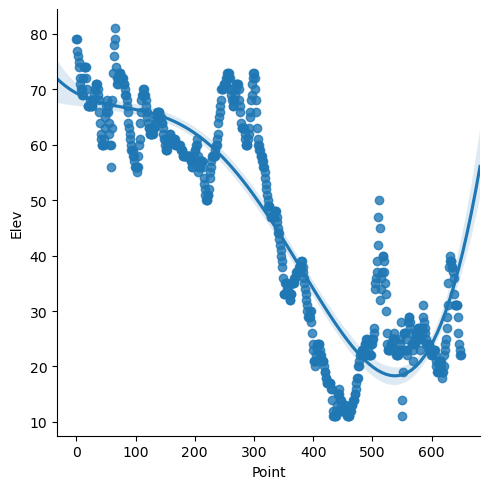

In [49]:
sns.lmplot(data=trek_proj, x='Point', y='Elev', order=4, truncate=False);

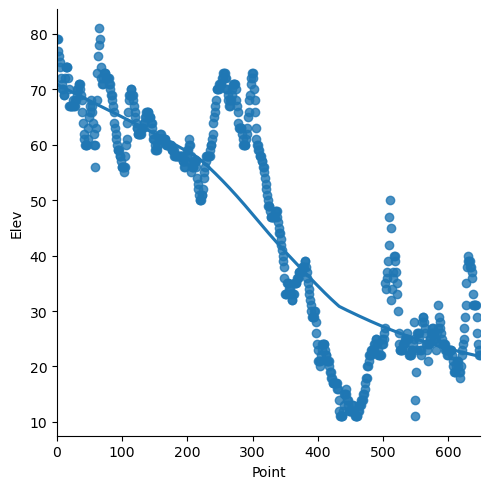

In [50]:
sns.lmplot(data=trek_proj, x='Point', y='Elev', lowess=True, truncate=False);

In [51]:
line = LineString(trek_proj.geometry)
print(f'''
    The walk was {line.length / 1000:.1f} kilometers
    Elevations: 
        Initial:   {trek_proj.iloc[0].Elev} meters 
        Final:     {trek_proj.iloc[-1].Elev} meters 
        Highest:   {trek_proj.Elev.max()} meters 
        Lowest:    {trek_proj.Elev.min()} meters 
''')


    The walk was 7.0 kilometers
    Elevations: 
        Initial:   79 meters 
        Final:     22 meters 
        Highest:   81 meters 
        Lowest:    11 meters 



In [52]:
trek_gdf.to_file('data/trek.gpkg', driver='GPKG')
trek_proj.to_file('data/trek_proj.gpkg', driver='GPKG')